# Task
Find the actual component values of the bandpass filter in fig. 1.

1. Compare the measured response voltage $U_a$ with the predicted response voltage under nominal component values.
2. Determine the root mean square error (rmse). 
3. Calculate the rmse for different values of $L$ and $C$.
4. Minimize the rmse function to find the actual component values.

![Circuit Diagramm](circuit.png)

In [87]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci

# Get Data

In [88]:
COIL=9e-3
CAPACITOR=1000e-6

def load_measured_data(filename):    
    # import measured data from file and return DataFrame
    with np.load(filename) as file:
        return pd.DataFrame({"time" : file["t_mess"], "measured" : file["u_a_mess"]})

def predicted_voltage_singe_input(coil, capacitor):
    # return calculated voltage by creating LTI System with given parameters
    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    return INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

u_a = load_measured_data("messwerte.npz")
u_a["predicted"] = predicted_voltage_singe_input(COIL, CAPACITOR) # append dataframe with predicted values

# Analysis
## Plot Expected and Measured Data

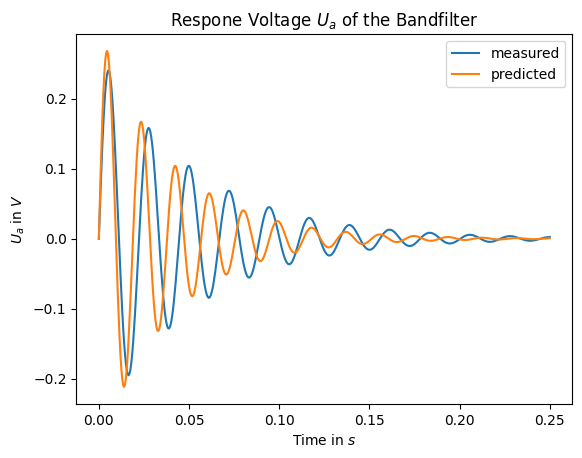

In [89]:
plt.plot(u_a["time"], u_a["measured"], label="measured")
plt.plot(u_a["time"], u_a["predicted"], label='predicted')

plt.title("Respone Voltage $U_a$ of the Bandfilter")
plt.xlabel("Time in $s$")
plt.ylabel("$U_a$ in $V$")
plt.legend()

plt.show()

## Calculate Root Mean Square Error

In [90]:
def root_mean_square_error(predicted): 
    # Calculate the root mean square error of 2 1D arrays
    return np.round(np.sqrt(1/len(predicted) * np.sum(np.square(np.subtract(predicted, u_a["measured"])))), 2)

rsme = root_mean_square_error(u_a["predicted"])
print(f"RSME with nominal values: {rsme} V")

RSME with nominal values: 0.06 V


# Modelling

## Create RMSE Grid

In [91]:
STEPS = 20
COIL_LOWER = 7e-3
COIL_UPPER = 12e-3
CAPACITOR_LOWER = 9 * 100e-6
CAPACITOR_UPPER = 16 * 100e-6

def resistor_list(lower, upper, steps):
    return np.linspace(lower, upper, steps)

def rsme_grid(coil_list, capacitor_list):
    # find rsme for each coil and capacitor values
    rsme = np.zeros((len(coil_list), len(capacitor_list)))   # reserve array space

    for i in range(len(coil_list)):
        for j in range(len(capacitor_list)):
            rsme[i][j] = root_mean_square_error(predicted_voltage_singe_input(coil_list[i], capacitor_list[j]))

    return rsme

coil_list = resistor_list(COIL_LOWER, COIL_UPPER, STEPS)
capacitor_list = resistor_list(CAPACITOR_LOWER, CAPACITOR_UPPER, STEPS)

Z = rsme_grid(coil_list, capacitor_list)

## Plot RSME Contour and Surface

C:\Users\janho\AppData\Local\Temp\ipykernel_19580\1021127366.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(coil_list, capacitor_list, Z, label="RSME")


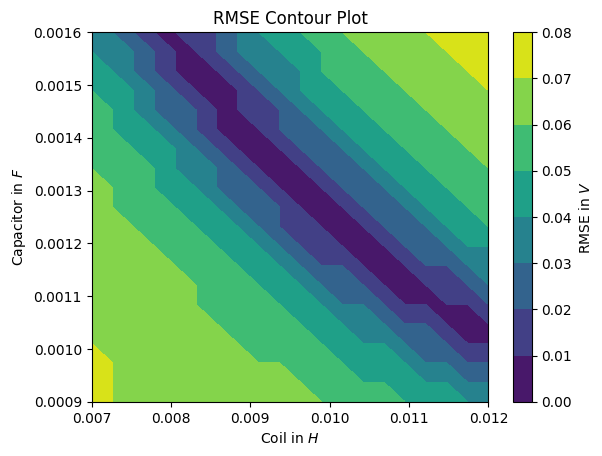

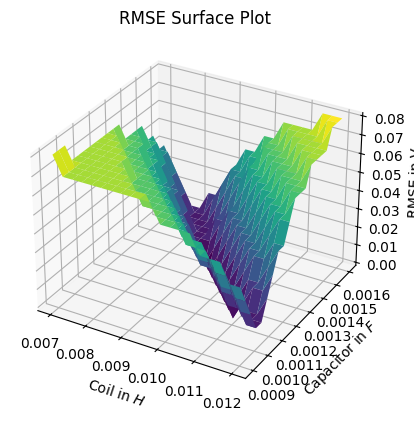

In [107]:
# Create Contour Plot
plt.contourf(coil_list, capacitor_list, Z, label="RSME")
plt.title('RMSE Contour Plot')
plt.xlabel('Coil in $H$')
plt.ylabel('Capacitor in $F$')
plt.colorbar(label='RMSE in $V$')
plt.show()

x,y = np.meshgrid(coil_list, capacitor_list)

# Create a 3D plot
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x, y, Z, cmap='viridis')
plt.title('RMSE Surface Plot')
ax.set_xlabel('Coil in $H$')
ax.set_ylabel('Capacitor in $F$')
ax.set_zlabel('RMSE in V')
plt.show()

## Minimize rsme with variable parameters

In [110]:
def rsme_singel_input(params):
    # redefine rms function to work with a single input variable.
    # params is a 1d array. first element is the coil, second element is the capacitor.

    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*params[1]), 0]
    denominator=[1, 1/(RESISTOR*params[1]), 1/(params[0]*params[1])]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    voltage =  INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

    return root_mean_square_error(voltage)

# initial_guess = [COIL, CAPACITOR]
INITIAL_GUESS = [0.01, 0.0013]
BOUNDS = [(COIL_LOWER, COIL_UPPER),(CAPACITOR_LOWER, CAPACITOR_UPPER)]

# ! rsme function retuns discrete values. Thereby minimize can't calculate a gradient. 
result = sci.optimize.dual_annealing(rsme_singel_input, BOUNDS, x0=INITIAL_GUESS)
# result = sci.optimize.minimize(rsme_singel_input, initial_guess, tol = 1e-15)
print(result)

best_coil, best_capacitor = result.x
min_rmse = result.fun

print(f"Optimal COIL: {best_coil}, Optimal CAPACITOR: {best_capacitor}, Minimum RMSE: {min_rmse}")

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 0.0
       x: [ 9.498e-03  1.302e-03]
     nit: 1000
    nfev: 4007
    njev: 2
    nhev: 0
Optimal COIL: 0.009498355675411262, Optimal CAPACITOR: 0.0013019790107708707, Minimum RMSE: 0.0
